In [1]:
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO
import yfinance as yf

import pyfolio as pf

from stable_baselines3.common.vec_env import DummyVecEnv
from env.train_env import StockEnvTrain
from env.trade_env import StockEnvTrade
from model.models import *
from config import config
from preprocessing.preprocessors import *
import run_DRL

import warnings
from peewee import ensure_entity
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\95271\anaconda3\envs\capstone\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = pd.to_datetime(strategy_ret.index)
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [3]:
def train_and_test_agent(agent_class, model_name, timestep, trade_start_date, trade_end_date):
    # Train the agent
    agent = agent_class('MlpPolicy', env_train, verbose=0)
    agent.learn(total_timesteps= timestep)

    # Prepare trade environment
    trade = data_split(df, start=trade_start_date, end=trade_end_date)
    env_trade = DummyVecEnv([lambda: StockEnvTrade(trade, 
                                                   turbulence_threshold=1e6, 
                                                   is_initial=True, 
                                                   previous_state=[],
                                                   model_name=model_name, 
                                                   iteration=trade_end_date, 
                                                   seed=42)])
    obs_trade = env_trade.reset()
    done = False
    last_state = []
    
    while not done:
        action, _states = agent.predict(obs_trade)
        obs_trade, rewards, done, info = env_trade.step(action)
    last_state = info[0]['terminal_observation']
    
    # Save last state
    pd.DataFrame({'last_state': list(last_state)}).to_csv(f'{config.results_dir}/last_state_{model_name}_{trade_end_date}.csv', index=False)

    # Load account value for the strategy
    df_model = pd.read_csv(f'{config.results_dir}/account_value_trade_{model_name}_{trade_end_date}.csv')
    df_model['Date'] = pd.to_datetime(df_model['datadate'], format='%Y%m%d')
    df_model['daily_return'] = df_model['account_value'].pct_change(1)
    return df_model

# Ensemble Strategy

In [4]:
rebalance_window = 63
validation_window = 63

df = pd.read_csv('done_data_2009-01-01_2020-12-31.csv')
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()

In [5]:
df_account_value = pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/2024-11-02_05-29-33/account_value_trade_ensemble_{}.csv'.format(unique_trade_date[i]))
    df_account_value = df_account_value.append(temp,ignore_index=True)
        
df_account_value['datadate'] = pd.to_datetime(df_account_value['datadate'], format='%Y%m%d')
df_account_value.head()

,datadate,account_value
0,2016-01-04,1000000.000000
1,2016-01-05,999710.018130
2,2016-01-06,997486.428166
3,2016-01-07,994277.042664
4,2016-01-08,992676.710782


In [6]:
# Calculate the daily return of the ensemble strategy
df_account_value['daily_return'] = df_account_value['account_value'].pct_change(1)
df_account_value.head()

,datadate,account_value,daily_return
0,2016-01-04,1000000.000000,NaN
1,2016-01-05,999710.018130,-0.000290
2,2016-01-06,997486.428166,-0.002224
3,2016-01-07,994277.042664,-0.003217
4,2016-01-08,992676.710782,-0.001610


## Import DJI Index Data

In [7]:
ticker = "^DJI"

# Decide the dates for DJI comparison
start_date = df_account_value['datadate'].min().strftime('%Y-%m-%d')
end_date = df_account_value['datadate'].max().strftime('%Y-%m-%d')

dji_data = yf.download(ticker, start= start_date, end= end_date)
dji_data['daily_return'] = dji_data['Adj Close'].pct_change(1)
dji_data.reset_index(inplace=True)
dji_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,daily_return
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000,NaN
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000,0.000567
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000,-0.014695
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000,-0.023211
4,2016-01-08,16519.169922,16651.890625,16314.570312,16346.450195,16346.450195,141850000,-0.010152


## Import individual agents' performance

In [8]:
train_start_date = 20090000
train_end_date = 20160104
trade_end_date = 20200707

train = data_split(df, start = train_start_date, end = train_end_date)
env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

In [9]:
df_a2c = train_and_test_agent(A2C, "A2C", 30000, train_end_date, trade_end_date)
df_ddpg = train_and_test_agent(DDPG, "DDPG", 5000, train_end_date, trade_end_date)
df_ppo = train_and_test_agent(PPO, "PPO", 80000, train_end_date, trade_end_date)

In [10]:
df_account_value['cumret'] = (1 + df_account_value['daily_return']).cumprod() - 1
df_a2c['cumret'] = (1 + df_a2c['daily_return']).cumprod() - 1
df_ddpg['cumret'] = (1 + df_ddpg['daily_return']).cumprod() - 1
df_ppo['cumret'] = (1 + df_ppo['daily_return']).cumprod() - 1
dji_data['cumret'] = (1 + dji_data['daily_return']).cumprod() - 1

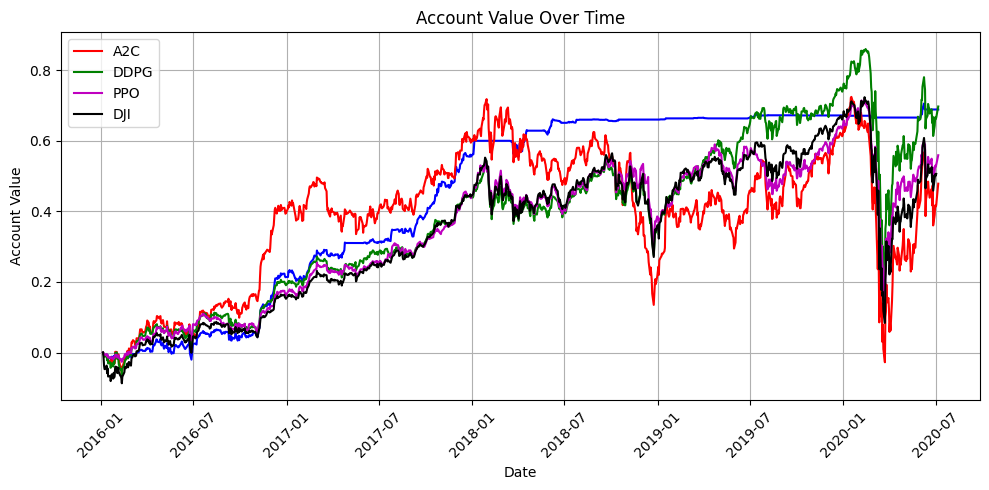

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(df_account_value['datadate'], df_account_value['cumret'], linestyle='-', color='b')
plt.plot(df_a2c['Date'], df_a2c['cumret'], linestyle='-', color='r', label='A2C')
plt.plot(df_ddpg['Date'], df_ddpg['cumret'], linestyle='-', color='g', label='DDPG')
plt.plot(df_ppo['Date'], df_ppo['cumret'], linestyle='-', color='m', label='PPO')
plt.plot(dji_data['Date'], dji_data['cumret'], linestyle='-', color='k', label='DJI')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Account Value Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [12]:
# Compare the two strategies
df_account_value.rename(columns={'datadate':'Date'}, inplace=True)
ensemble_strat = backtest_strat(df_account_value)
dow_strat = backtest_strat(dji_data)

Start date,2016-01-04
End date,2020-07-02
Total months,53
,Backtest
Annual return,12.355%
Cumulative returns,68.837%
Annual volatility,6.53%
Sharpe ratio,1.82
Calmar ratio,2.19
Stability,0.83
Max drawdown,-5.636%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.64,2016-04-27,2016-06-27,2016-07-08,53
1,2.97,2016-08-15,2016-09-14,2016-11-07,61
2,2.87,2018-01-05,2018-04-02,2018-04-12,70
3,2.57,2017-01-06,2017-01-31,2017-02-13,27
4,2.20,2016-01-04,2016-02-11,2016-03-14,51


Stress Events,mean,min,max
New Normal,0.05%,-3.48%,2.68%


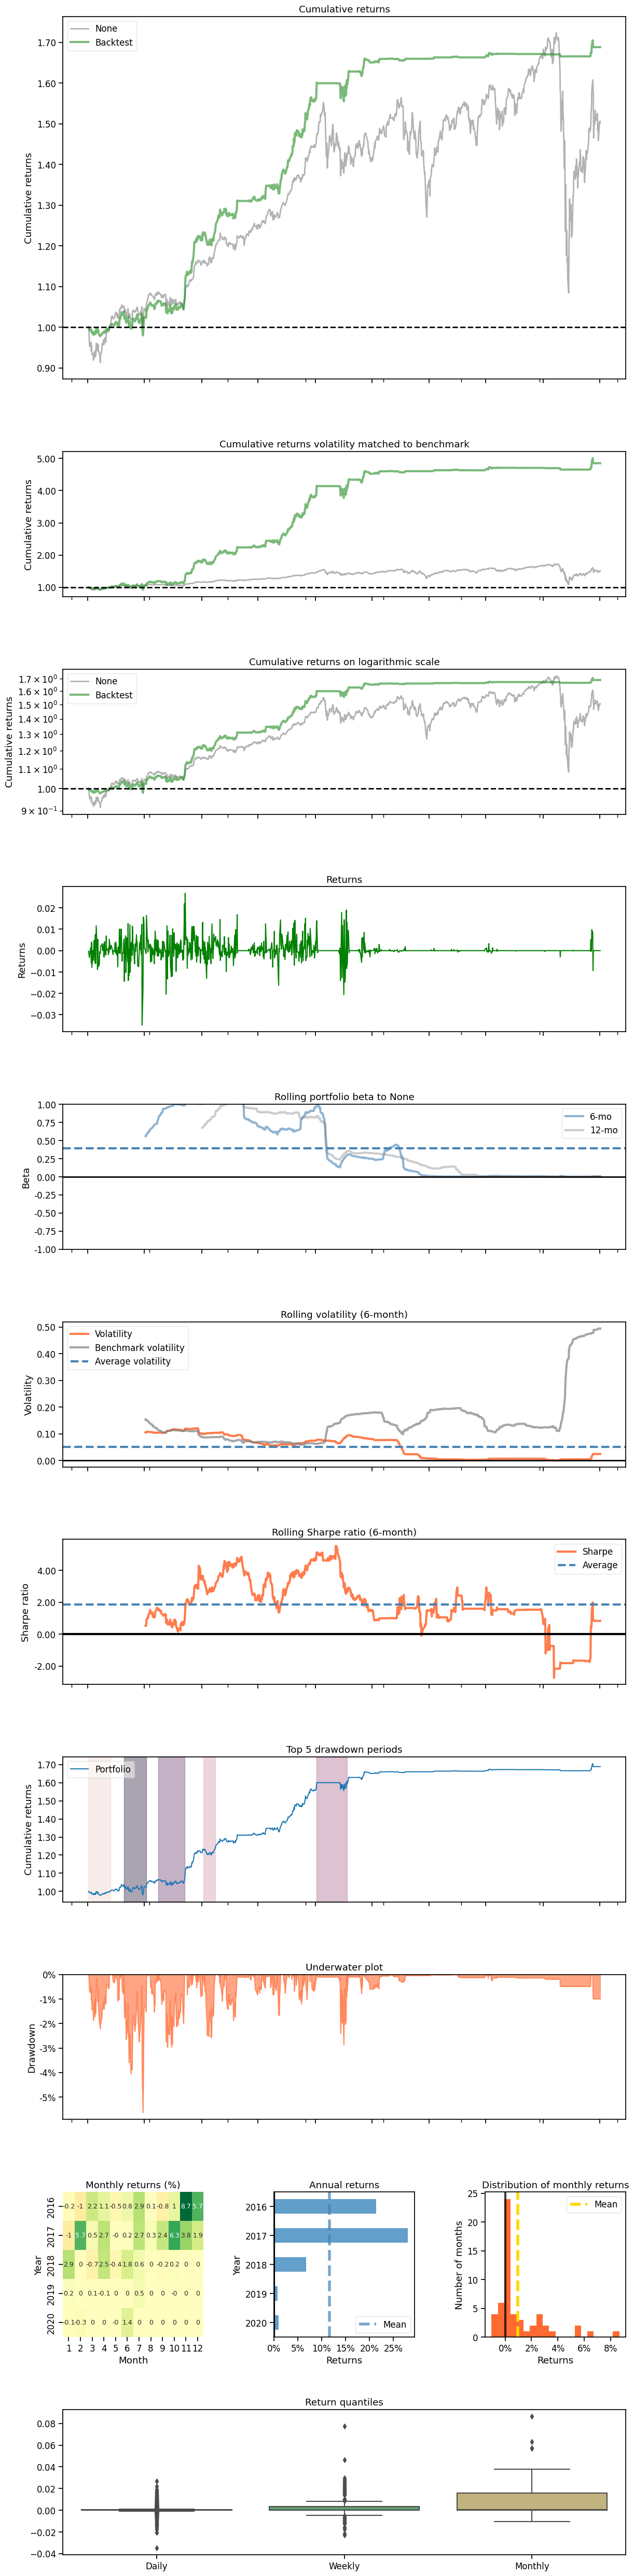

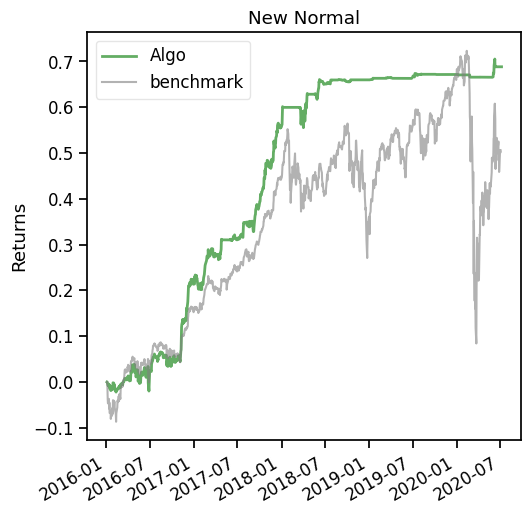

In [13]:
with pf.plotting.plotting_context(font_scale=1.1):
    pf.create_full_tear_sheet(returns=ensemble_strat, benchmark_rets=dow_strat, set_context=False)